In [3]:
import pandas as pd

# Danh sách file cụ thể
file_paths = [
    "ACB.csv", "BCM.csv", "BID.csv", "BVH.csv", "CTG.csv", "FPT.csv", "GAS.csv", "GVR.csv", "HDB.csv", "HPG.csv",
    "LPB.csv", "MBB.csv", "MSN.csv", "MWG.csv", "PLX.csv", "SAB.csv", "SHB.csv", "SSB.csv", "SSI.csv", "STB.csv",
    "TCB.csv", "TPB.csv", "VCB.csv", "VHM.csv", "VIB.csv", "VIC.csv", "VJC.csv", "VNM.csv", "VPB.csv", "VRE.csv"
]

# Chỉ giữ lại các cột cần thiết
columns_needed = ['period', 'quarter', 'year', 'price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Đọc và gộp dữ liệu
df_list = []
for file in file_paths:
    try:
        df = pd.read_csv(file)[columns_needed]  # Chỉ lấy các cột cần thiết
        df["company"] = file.replace(".csv", "")  # Thêm cột tên công ty
        df_list.append(df)
    except Exception as e:
        print(f"Lỗi khi đọc file {file}: {e}")

df_combined = pd.concat(df_list, ignore_index=True)

# Lưu file kết quả
df_combined.to_csv("Merged_data.csv", index=False)

print("✅ Gộp dữ liệu hoàn tất! File lưu thành 'Merged_data.csv'")


✅ Gộp dữ liệu hoàn tất! File lưu thành 'Merged_data.csv'


## 1.1. Giả thuyết 1

### Kiểm định ANOVA: P/E, PB, ROE, EPS trung bình có khác biệt giữa các công ty?
- $\mathcal{H}_0$ (Giả thuyết không): Không có sự khác biệt đáng kể giữa các công ty.
- $\mathcal{H}_1$ (Giả thuyết đối): Ít nhất một công ty có tiêu chí khác biệt đáng kể.

In [53]:
import scipy.stats as stats

# Danh sách tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

for criterion in criteria:
    # Tạo danh sách nhóm dữ liệu hợp lệ
    groups = [df_combined[df_combined['company'] == company][criterion].dropna() 
              for company in df_combined['company'].unique()]
    
    # Kiểm tra xem có ít nhất 2 nhóm hợp lệ không
    if len(groups) < 2 or any(len(group) < 2 for group in groups):
        print(f"⚠️ Không đủ dữ liệu để thực hiện ANOVA cho {criterion} (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)\n")
        continue

    # Kiểm định ANOVA
    stat, p_value = stats.f_oneway(*groups)
    
    print(f"🔹 ANOVA cho {criterion}: F-statistic = {stat:.4f}, p-value = {p_value:.4f}")

    # Kiểm tra ý nghĩa thống kê
    if p_value < 0.05:
        print(f"  → Có sự khác biệt đáng kể về {criterion} giữa các công ty (p < 0.05)\n")
    else:
        print(f"  → Không có sự khác biệt đáng kể về {criterion} giữa các công ty (p >= 0.05)\n")


🔹 ANOVA cho price_to_earning: F-statistic = 5.7699, p-value = 0.0000
  → Có sự khác biệt đáng kể về price_to_earning giữa các công ty (p < 0.05)

🔹 ANOVA cho price_to_book: F-statistic = 53.7497, p-value = 0.0000
  → Có sự khác biệt đáng kể về price_to_book giữa các công ty (p < 0.05)

🔹 ANOVA cho roe: F-statistic = 31.7958, p-value = 0.0000
  → Có sự khác biệt đáng kể về roe giữa các công ty (p < 0.05)

🔹 ANOVA cho earning_per_share: F-statistic = 38.2516, p-value = 0.0000
  → Có sự khác biệt đáng kể về earning_per_share giữa các công ty (p < 0.05)



## 1.2. Giả thuyết 2

###  T-Test: Các tiêu chí trung bình trước và sau năm 2020 có khác biệt đáng kể?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể về các tiêu chí trung bình trước và sau năm 2020.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể về doanh thu trung bình giữa hai giai đoạn.

In [43]:
import pandas as pd
from scipy.stats import ttest_ind


# Chuyển đổi kiểu dữ liệu của cột 'year' (nếu chưa phải số)
df_combined['year'] = pd.to_numeric(df_combined['year'], errors='coerce')

# Tách dữ liệu thành hai nhóm
df_before_2020 = df_combined[df_combined['year'] < 2020]
df_after_2020 = df_combined[df_combined['year'] >= 2020]

# Danh sách các tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện T-Test cho từng tiêu chí
t_test_results = {}
for crit in criteria:
    t_stat, p_value = ttest_ind(df_before_2020[crit].dropna(), df_after_2020[crit].dropna(), equal_var=False)
    t_test_results[crit] = {'T-Statistic': t_stat, 'P-Value': p_value}

# Hiển thị kết quả
for crit, result in t_test_results.items():
    print(f"🔹 Kiểm định T-Test cho {crit}:")
    print(f"   - T-Statistic: {result['T-Statistic']:.4f}")
    print(f"   - P-Value: {result['P-Value']:.4f}")
    if result['P-Value'] < 0.05:
        print("   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.")
    else:
        print("   ❌ Không có sự khác biệt đáng kể giữa trước và sau 2020.")
    print("-" * 50)


🔹 Kiểm định T-Test cho price_to_earning:
   - T-Statistic: -2.0929
   - P-Value: 0.0366
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho price_to_book:
   - T-Statistic: 4.0618
   - P-Value: 0.0001
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho roe:
   - T-Statistic: 3.4436
   - P-Value: 0.0006
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho earning_per_share:
   - T-Statistic: -3.4525
   - P-Value: 0.0006
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------


## 1.3. Giả thuyết 3

###  T-Test: Các tiêu chí trung bình giữa nhóm ngành ngân hàng và bất động sản có khác biệt đáng kể?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể giữa nhóm ngành ngân hàng và bất động sản.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể về doanh thu trung bình giữa hai giai đoạn.

In [15]:
import pandas as pd
from scipy.stats import ttest_ind


# Xác định nhóm công ty
banking_companies = ["ACB", "BID", "CTG", "HDB", "LPB", "MBB", "SHB", "SSB", "STB", "TCB", "TPB", "VCB", "VIB", "VPB"]
real_estate_companies = ["BCM", "VHM", "VIC", "VRE"]

# Lọc dữ liệu theo từng nhóm
df_banking = df_combined[df_combined["company"].isin(banking_companies)]
df_real_estate = df_combined[df_combined["company"].isin(real_estate_companies)]

# Các tiêu chí cần kiểm định
criteria = ["price_to_earning", "price_to_book", "roe", "earning_per_share"]

# Tiến hành kiểm định T-test cho từng tiêu chí
results = {}
for criterion in criteria:
    t_stat, p_value = ttest_ind(df_banking[criterion].dropna(), df_real_estate[criterion].dropna(), equal_var=False)
    results[criterion] = {"t-statistic": t_stat, "p-value": p_value}

# Hiển thị kết quả
for criterion, res in results.items():
    print(f"🔹 Tiêu chí: {criterion}")
    print(f"   - T-statistic: {res['t-statistic']:.4f}")
    print(f"   - P-value: {res['p-value']:.4f}")
    if res["p-value"] < 0.05:
        print("   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm\n")
    else:
        print("   ❌ Kết luận: Không có sự khác biệt đáng kể giữa hai nhóm\n")


🔹 Tiêu chí: price_to_earning
   - T-statistic: -2.7742
   - P-value: 0.0064
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: price_to_book
   - T-statistic: -9.0976
   - P-value: 0.0000
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: roe
   - T-statistic: 3.7414
   - P-value: 0.0003
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: earning_per_share
   - T-statistic: -2.4577
   - P-value: 0.0154
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm



In [8]:
print(df_combined.columns)  # Kiểm tra các cột có trong DataFrame


Index(['period', 'quarter', 'year', 'price_to_earning', 'price_to_book', 'roe',
       'earning_per_share', 'company'],
      dtype='object')


## 1.4. Giả thuyết 4

### Kiểm định xu hướng Mann-Kendall: Các tiêu chí P/E/ P/B, ROE, EPS có xu hướng tăng/giảm theo thời gian không?
- $\mathcal{H}_0$: Không có xu hướng tăng hoặc giảm rõ ràng của các tiêu chí theo thời gian.
- $\mathcal{H}_1$: Có xu hướng tăng hoặc giảm theo thời gian.

In [18]:
import pandas as pd
import numpy as np
import pymannkendall as mk

# Đảm bảo dữ liệu được sắp xếp theo thời gian
df_combined = df_combined.sort_values(by=["year", "quarter"])

# Chọn các tiêu chí cần kiểm định
columns_to_test = ["price_to_earning", "price_to_book", "roe", "earning_per_share"]

# Kiểm định Mann-Kendall cho từng công ty
results = []
for company in df_combined["company"].unique():
    df_company = df_combined[df_combined["company"] == company]
    
    for col in columns_to_test:
        trend_result = mk.original_test(df_company[col].dropna())  # Sửa chỗ này
        
        results.append({
            "company": company,
            "criteria": col,
            "trend": trend_result.trend,  # Xu hướng: 'increasing', 'decreasing', 'no trend'
            "p_value": trend_result.p
        })

# Chuyển kết quả thành DataFrame
df_results = pd.DataFrame(results)

# Lưu kết quả
df_results.to_csv("Mann_kendall_results.csv", index=False)

print("✅ Kiểm định Mann-Kendall hoàn tất! Kết quả được lưu trong 'mann_kendall_results.csv'.")
df_results.head(12)


✅ Kiểm định Mann-Kendall hoàn tất! Kết quả được lưu trong 'mann_kendall_results.csv'.


,company,criteria,trend,p_value
0,HDB,price_to_earning,decreasing,8.279607e-05
1,HDB,price_to_book,decreasing,1.168305e-02
2,HDB,roe,increasing,1.070137e-10
3,HDB,earning_per_share,increasing,5.995204e-14
4,ACB,price_to_earning,decreasing,7.797287e-07
5,ACB,price_to_book,no trend,5.257137e-01
6,ACB,roe,increasing,8.540264e-05
7,ACB,earning_per_share,increasing,0.000000e+00
8,BID,price_to_earning,no trend,6.080288e-01
9,BID,price_to_book,no trend,1.602768e-01


## 1.5. Giả thuyết 5

###  T-Test: Các tiêu chí trung bình giữa 2 qúy đầu năm và 2 quý cuối năm có khác biệt đáng kể?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể giữa 2 qúy đầu năm và 2 quý cuối năm.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể về trung bình các tiêu chí giữa hai giai đoạn.

In [50]:
import pandas as pd
from scipy import stats

# Chỉ lấy các cột cần thiết
columns_needed = ['quarter', 'price_to_earning', 'price_to_book', 'roe', 'earning_per_share']
df1 = df_combined[columns_needed]

# Chia dữ liệu thành hai nhóm: 2 quý đầu và 2 quý sau
df1_q1_q2 = df1[df1['quarter'].isin([1, 2])]  # Nhóm quý 1, 2
df1_q3_q4 = df1[df1['quarter'].isin([3, 4])]  # Nhóm quý 3, 4

# Danh sách các tiêu chí để kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện kiểm định T-Test
results = {}
for criterion in criteria:
    t_stat, p_value = stats.ttest_ind(df1_q1_q2[criterion].dropna(), df1_q3_q4[criterion].dropna(), equal_var=False)
    results[criterion] = {"T-Statistic": t_stat, "P-Value": p_value}

# In kết quả kiểm định
print("📌 Kết quả kiểm định T-Test giữa 2 quý đầu và 2 quý sau:")
for key, value in results.items():
    print(f"\n🔹 {key}:")
    print(f"   T-Statistic = {value['T-Statistic']:.4f}")
    print(f"   P-Value     = {value['P-Value']:.4f}")

    # Đánh giá kết quả
    if value["P-Value"] < 0.05:
        print("   ✅ Kết luận: Có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.")
    else:
        print("   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.")


📌 Kết quả kiểm định T-Test giữa 2 quý đầu và 2 quý sau:

🔹 price_to_earning:
   T-Statistic = -1.2386
   P-Value     = 0.2158
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 price_to_book:
   T-Statistic = 0.2235
   P-Value     = 0.8232
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 roe:
   T-Statistic = 0.0845
   P-Value     = 0.9326
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 earning_per_share:
   T-Statistic = -1.0155
   P-Value     = 0.3101
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.


## 1.6. Giả thuyết 6

### Kiểm định tương quan Pearson: Các tiêu chí có tương quan dương?
- $\mathcal{H}_0$: Không có mối tương quan đáng kể giữa các tiêu chí.
- $\mathcal{H}_1$: Có tương quan giữa các tiêu chí.

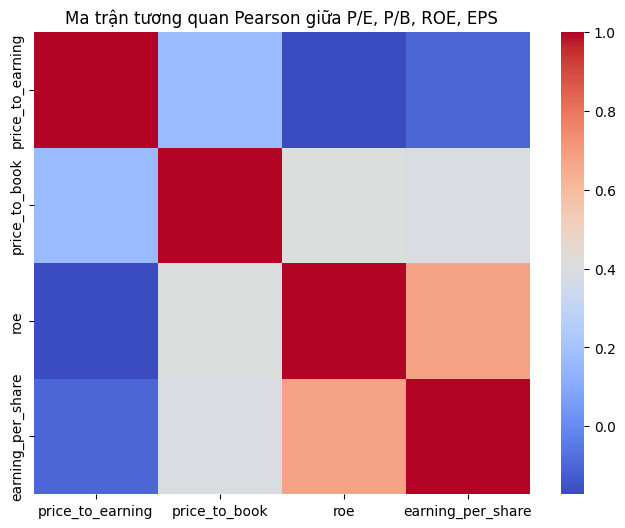


✅ Ma trận p-value (kiểm định ý nghĩa thống kê):


,price_to_earning,price_to_book,roe,earning_per_share
price_to_earning,1.000000e+00,1.208417e-07,3.915086e-08,1.457037e-03
price_to_book,1.208417e-07,1.000000e+00,2.952686e-42,1.704635e-39
roe,3.915086e-08,2.952686e-42,1.000000e+00,8.917200e-136
earning_per_share,1.457037e-03,1.704635e-39,8.917200e-136,1.000000e+00


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


# Chọn các cột cần phân tích
columns_of_interest = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']
df_selected = df_combined[columns_of_interest].dropna()  # Loại bỏ dữ liệu bị thiếu

# Tính ma trận hệ số tương quan Pearson
correlation_matrix = df_selected.corr(method='pearson')

# Vẽ heatmap biểu diễn ma trận tương quan
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Ma trận tương quan Pearson giữa P/E, P/B, ROE, EPS")
plt.show()

# Tính p-value cho từng cặp biến
p_values = df_selected.corr(method=lambda x, y: stats.pearsonr(x, y)[1])  # Lấy p-value

print("\n✅ Ma trận p-value (kiểm định ý nghĩa thống kê):")
p_values.head()


📌 $\textbf{Kết luận}$
- Hệ số tương quan dương mạnh nhất:

    - ROE và EPS có tương quan mạnh (0.678, p-value ≈ 0), tức là ROE tăng thì EPS cũng có xu hướng tăng đáng kể.

    - P/B và ROE có tương quan dương khá cao (0.412, p-value ≈ 0), nghĩa là ROE cao thường đi kèm với giá trị sổ sách trên cổ phiếu cao hơn.

- Hệ số tương quan âm:
    - P/E và ROE có tương quan âm nhỏ (-0.173, p-value ≈ 0), cho thấy khi ROE tăng thì P/E có xu hướng giảm nhẹ (có thể do nhà đầu tư trả giá thấp hơn cho cổ phiếu có lợi nhuận cao).

- P-value rất nhỏ (<0.05) ở hầu hết các cặp, chứng tỏ các mối quan hệ đều có ý nghĩa thống kê.

👉 Tóm lại: EPS, ROE và P/B có mối tương quan đáng kể, trong khi P/E có tương quan yếu hơn với các tiêu chí khác.

## 1.7. Giả thuyết 7

### Kiểm định Kruskal-Wallis: Các tiêu chí trung bình có khác nhau giữa các công ty?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể về trung bình các tiêu chí (P/E, P/B, ROE, EPS) giữa các khu vực.
- $\mathcal{H}_1$: Có ít nhất một khu vực có tiêu chí khác biệt đáng kể.

In [23]:
import pandas as pd
from scipy.stats import kruskal

# Xác định danh sách tiêu chí cần kiểm định
criteria = ["price_to_earning", "price_to_book", "roe", "earning_per_share"]

# Thực hiện kiểm định Kruskal-Wallis
results = {}

for criterion in criteria:
    groups = [df_combined[df_combined["company"] == company][criterion].dropna() 
              for company in df_combined["company"].unique()]
    
    stat, p_value = kruskal(*groups)
    results[criterion] = (stat, p_value, "Có sự khác biệt đáng kể" if p_value < 0.05 else "Không có sự khác biệt đáng kể")

# Hiển thị kết quả
for criterion, (stat, p_value, conclusion) in results.items():
    print(f"Kết quả kiểm định Kruskal-Wallis cho {criterion}:")
    print(f"  - Hệ số thống kê (H): {stat:.4f}")
    print(f"  - Giá trị p: {p_value:.4f}")
    print(f"  ✅ Kết luận: {conclusion}")
    print("-" * 50)


Kết quả kiểm định Kruskal-Wallis cho price_to_earning:
  - Hệ số thống kê (H): 556.4345
  - Giá trị p: 0.0000
  ✅ Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho price_to_book:
  - Hệ số thống kê (H): 649.7852
  - Giá trị p: 0.0000
  ✅ Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho roe:
  - Hệ số thống kê (H): 540.9364
  - Giá trị p: 0.0000
  ✅ Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------
Kết quả kiểm định Kruskal-Wallis cho earning_per_share:
  - Hệ số thống kê (H): 524.8949
  - Giá trị p: 0.0000
  ✅ Kết luận: Có sự khác biệt đáng kể
--------------------------------------------------


## 2. Tạo đặc trưng mới và thực hiện kiểm chứng các giả thuyết

In [26]:
# Gán nhóm ngành cho từng công ty
industry_mapping = {
    "ACB": "Banking", "BID": "Banking", "CTG": "Banking", "HDB": "Banking", "LPB": "Banking",
    "MBB": "Banking", "SHB": "Banking", "SSB": "Banking", "STB": "Banking", "TCB": "Banking",
    "TPB": "Banking", "VCB": "Banking", "VIB": "Banking", "VPB": "Banking",
    "VHM": "Real Estate", "VIC": "Real Estate", "NVL": "Real Estate",
    "MSN": "Consumer Goods", "MWG": "Consumer Goods", "SAB": "Consumer Goods", "VNM": "Consumer Goods",
    "GAS": "Energy", "PLX": "Energy",
    "FPT": "Technology", "BVH": "Insurance", "HPG": "Materials", "GVR": "Materials",
    "SSI": "Financial Services"
}

# Thêm cột nhóm ngành
df_combined["industry"] = df_combined["company"].map(industry_mapping).fillna("Other")

# Kiểm tra kết quả
df_combined.head()


,period,quarter,year,price_to_earning,price_to_book,roe,earning_per_share,company,industry
316,2014-Q1,1,2014,NaN,NaN,0.026,92.0,HDB,Banking
39,2015-Q1,1,2015,15.0,1.2,0.077,363.0,ACB,Banking
102,2015-Q1,1,2015,10.6,1.6,0.154,1311.0,BID,Banking
142,2015-Q1,1,2015,18.2,NaN,NaN,1673.0,BVH,Insurance
182,2015-Q1,1,2015,9.6,1.0,0.104,1211.0,CTG,Banking


In [78]:
# 🔹 Tạo 4 đặc trưng mới
df_combined['pe_roe_ratio'] = df_combined['price_to_earning'] / df_combined['roe']
df_combined['pb_roe_ratio'] = df_combined['price_to_book'] / df_combined['roe']
df_combined['eps_quarter_growth'] = df_combined.groupby('company')['earning_per_share'].pct_change()
df_combined['roe_moving_avg'] = df_combined.groupby('company')['roe'].rolling(window=2).mean().reset_index(level=0, drop=True)

# Loại bỏ giá trị NaN sinh ra do `pct_change` và `rolling`
df.dropna(inplace=True)


## 2.1. Giả thuyết 8

### Kiểm định ANOVA: Giá trị trung bình của pe_roe_ratio có khác nhau giữa các công ty không? (ANOVA)

- $\mathcal{H}_0$: Không có sự khác biệt về pe_roe_ratio trung bình giữa các công ty.
- $\mathcal{H}_1$: Có ít nhất một khu vực có pe_roe_ratio trung bình khác biệt đáng kể.

In [79]:
import scipy.stats as stats

anova_result = stats.f_oneway(*[df_combined[df_combined['company'] == c]['pe_roe_ratio'] for c in df_combined['company'].unique()])
print(f"ANOVA PE/ROE giữa các công ty: p-value = {anova_result.pvalue:.4f}")
if anova_result.pvalue < 0.05:
    print("⏩ Kết luận: Có sự khác biệt đáng kể về PE/ROE giữa các công ty.")
else:
    print("⏩ Kết luận: Không có sự khác biệt đáng kể về PE/ROE giữa các công ty.")



ANOVA PE/ROE giữa các công ty: p-value = 0.0000
⏩ Kết luận: Có sự khác biệt đáng kể về PE/ROE giữa các công ty.


## 2.2. Giả thuyết 9

### Kiểm định Pearson: PB/ROE có mối tương quan với EPS không?
- $\mathcal{H}_0$: Không có mối tương quan giữa PB/ROE với EPS.
- $\mathcal{H}_1$: Có mối tương quan đáng kể giữa PB/ROE với EPS.

In [81]:
corr, p_value = stats.pearsonr(df_combined['pb_roe_ratio'], df_combined['earning_per_share'])
print(f"Tương quan PB/ROE với EPS: r = {corr:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⏩ Kết luận: Có mối tương quan đáng kể giữa PB/ROE và EPS.")
else:
    print("⏩ Kết luận: Không có mối tương quan đáng kể giữa PB/ROE và EPS.")


Tương quan PB/ROE với EPS: r = -0.1139, p-value = 0.0004
⏩ Kết luận: Có mối tương quan đáng kể giữa PB/ROE và EPS.


## 2.3. Giả thuyết 10

### T-Test: EPS có xu hướng tăng trưởng theo thời gian không? 

- $\mathcal{H}_0$: EPS không có xu hướng tăng trưởng đáng kể.
- $\mathcal{H}_1$: EPS có xu hướng tăng trưởng theo thời gian

In [82]:
eps_yearly = df_combined.groupby(['year'])['earning_per_share'].mean()
t_stat, p_value = stats.ttest_rel(eps_yearly[:-1], eps_yearly[1:])
print(f"T-test EPS theo năm: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⏩ Kết luận: EPS có xu hướng tăng trưởng theo thời gian.")
else:
    print("⏩ Kết luận: EPS không có xu hướng tăng trưởng đáng kể.")


T-test EPS theo năm: p-value = 0.2742
⏩ Kết luận: EPS không có xu hướng tăng trưởng đáng kể.


## 2.4. Giả thuyết 11

### T-Test: ROE trung bình của các công ty có giá trị PB trên trung bình có khác biệt đáng kể so với nhóm dưới trung bình không?

- $\mathcal{H}_0$: Không có sự khác biệt đáng kể về ROE giữa nhóm PB cao và thấp.
- $\mathcal{H}_1$: ROE trung bình có sự khác biệt đáng kể giữa hai nhóm PB.

In [83]:
median_pb = df_combined['price_to_book'].median()
group_high = df_combined[df_combined['price_to_book'] > median_pb]['roe']
group_low = df_combined[df_combined['price_to_book'] <= median_pb]['roe']
t_stat, p_value = stats.ttest_ind(group_high, group_low, equal_var=False)
print(f"T-test ROE giữa nhóm PB cao & thấp: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⏩ Kết luận: ROE trung bình có sự khác biệt đáng kể giữa nhóm PB cao và thấp.")
else:
    print("⏩ Kết luận: Không có sự khác biệt đáng kể về ROE giữa hai nhóm PB.")


T-test ROE giữa nhóm PB cao & thấp: p-value = 0.0000
⏩ Kết luận: ROE trung bình có sự khác biệt đáng kể giữa nhóm PB cao và thấp.


## 2.5. Giả thuyết 12

### Q-Q plot Test: ROE có phân phối chuẩn không? 

- $\mathcal{H}_0$: ROE không tuân theo phân phối chuẩn.
- $\mathcal{H}_1$: ROE có thể coi là tuân theo phân phối chuẩn.

✅ Phân phối có thể coi là gần chuẩn dựa trên Skewness & Kurtosis.



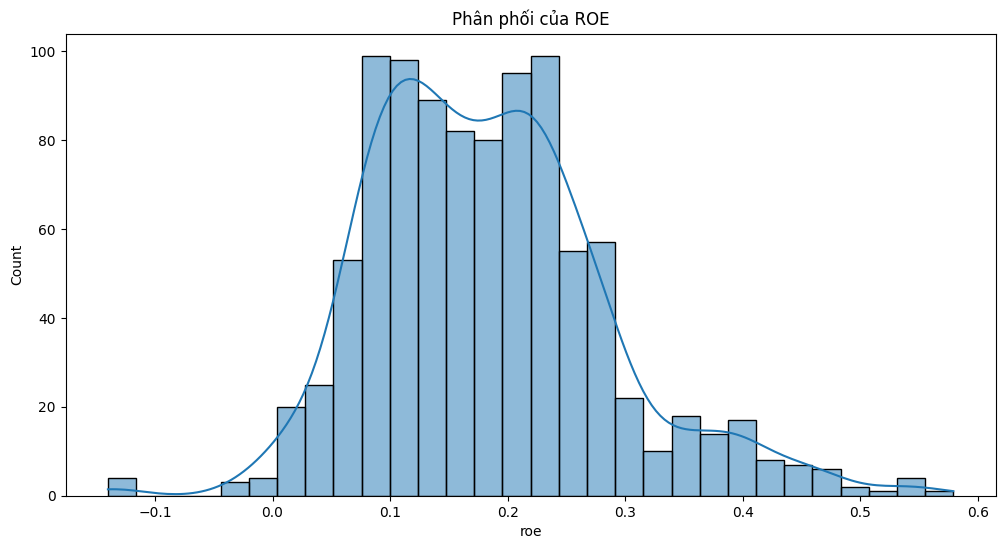

In [122]:
# 🔹 Kiểm tra Skewness & Kurtosis
skewness = stats.skew(df_combined['roe'])
kurt = stats.kurtosis(df_combined['roe'])

# 🔹 Kết luận
if abs(skewness) < 0.7 and abs(kurt) < 3.5:
    print("✅ Phân phối có thể coi là gần chuẩn dựa trên Skewness & Kurtosis.\n")
else:
    print("❌ Phân phối không tuân theo phân phối chuẩn do lệch hoặc có đuôi dài.\n")
# 🔹 3. Vẽ biểu đồ trực quan
plt.figure(figsize=(12, 6))
sns.histplot(df_combined['roe'], kde=True, bins=30)
plt.title("Phân phối của ROE")
plt.show()


## 3. Tính toán các độ đo kinh tế học và kiểm chứng giả thuyết

In [28]:
import pandas as pd

# Danh sách file cụ thể
file_paths = [
    "ACB.csv", "BCM.csv", "BID.csv", "BVH.csv", "CTG.csv", "FPT.csv", "GAS.csv", "GVR.csv", "HDB.csv", "HPG.csv",
    "LPB.csv", "MBB.csv", "MSN.csv", "MWG.csv", "PLX.csv", "SAB.csv", "SHB.csv", "SSB.csv", "SSI.csv", "STB.csv",
    "TCB.csv", "TPB.csv", "VCB.csv", "VHM.csv", "VIB.csv", "VIC.csv", "VJC.csv", "VNM.csv", "VPB.csv", "VRE.csv"
]

# Chỉ giữ lại các cột cần thiết
columns_needed = ['period', 'quarter', 'year', 'price_to_earning', 'price_to_book', 'roe', 'earning_per_share', 'equity_on_liability'
, 'asset_on_equity', 'equity_on_total_asset', 'roa', 'payable_on_equity', 'book_value_per_share_change', 'eps_change', 'book_value_per_share']

# Đọc và gộp dữ liệu
df_list = []
for file in file_paths:
    try:
        df = pd.read_csv(file)[columns_needed]  # Chỉ lấy các cột cần thiết
        df["company"] = file.replace(".csv", "")  # Thêm cột tên công ty
        df_list.append(df)
    except Exception as e:
        print(f"Lỗi khi đọc file {file}: {e}")

df_combined_full = pd.concat(df_list, ignore_index=True)

# Lưu file kết quả
df_combined_full.to_csv("Merged_data_full.csv", index=False)

print("✅ Gộp dữ liệu hoàn tất! File lưu thành 'Merged_data_full.csv'")

✅ Gộp dữ liệu hoàn tất! File lưu thành 'Merged_data_full.csv'


In [32]:
df_combined_full.head()

,period,quarter,year,price_to_earning,price_to_book,roe,earning_per_share,equity_on_liability,asset_on_equity,equity_on_total_asset,roa,payable_on_equity,book_value_per_share_change,eps_change,book_value_per_share,company,Adjusted_ROE,Adjusted_ROA,Equity_Liability_Ratio,FLI
0,2024-Q4,4,2024,7.0,1.4,0.217,3758.0,0.1,10.4,0.097,0.021,9.4,0.058,0.033,18685.0,ACB,0.3038,0.2184,0.1,107.216495
1,2024-Q3,3,2024,7.1,1.5,0.223,3638.0,0.1,9.9,0.101,0.023,8.9,0.054,-0.010,17653.0,ACB,0.3345,0.2277,0.1,98.019802
2,2024-Q2,2,2024,6.5,1.4,0.239,3675.0,0.1,10.3,0.097,0.023,9.3,0.000,0.038,16744.0,ACB,0.3346,0.2369,0.1,106.185567
3,2024-Q1,1,2024,6.8,1.4,0.230,3540.0,0.1,9.7,0.103,0.024,8.7,0.054,-0.014,16744.0,ACB,0.3220,0.2328,0.1,94.174757
4,2023-Q4,4,2023,5.6,1.3,0.248,3592.0,0.1,10.1,0.099,0.024,9.1,0.062,0.076,15885.0,ACB,0.3224,0.2424,0.1,102.020202


In [31]:
# Tính toán các độ đo kinh tế quan trọng


# **Hệ số ROE điều chỉnh (Adjusted ROE)**
df_combined_full["Adjusted_ROE"] = df_combined_full["roe"] * df_combined_full["price_to_book"]

# **Tỷ suất sinh lời trên tài sản có điều chỉnh (Adjusted ROA)**
df_combined_full["Adjusted_ROA"] = df_combined_full["roa"] * df_combined_full["asset_on_equity"]

# **Tỷ lệ vốn chủ sở hữu trên nợ phải trả (Equity/Liability Ratio)**
df_combined_full["Equity_Liability_Ratio"] = df_combined_full["equity_on_liability"]

# **Chỉ số đòn bẩy tài chính (Financial Leverage Index - FLI)**
df_combined_full['FLI'] = df_combined_full['asset_on_equity'] / df_combined_full['equity_on_total_asset']



## 3.1. Giả thuyết 13

### T-Test: Nhóm Adjusted_ROA cao và thấp có sự khác biệt đáng kể không ?

- $\mathcal{H}_0$: Không có sự khác biệt đáng kể giữa nhóm Adjusted_ROA cao và thấp.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể giữa 2 nhóm trên.

In [33]:

# Kiểm định t-test giữa nhóm Adjusted_ROA cao và thấp
high_roa = df_combined_full[df_combined_full['Adjusted_ROA'] > df_combined_full['Adjusted_ROA'].median()]['Adjusted_ROA']
low_roa = df_combined_full[df_combined_full['Adjusted_ROA'] <= df_combined_full['Adjusted_ROA'].median()]['Adjusted_ROA']
t_stat, pval = stats.ttest_ind(high_roa, low_roa, equal_var=False)
print(f"T-test statistic: {t_stat}, p-value: {pval}")
if pval < 0.05:
    print("✅ Có sự khác biệt đáng kể giữa nhóm Adjusted_ROA cao và thấp.")
else:
    print("❌ Không có sự khác biệt đáng kể giữa nhóm Adjusted_ROA cao và thấp.")

T-test statistic: 37.52026227192851, p-value: 2.5368805051550305e-182
✅ Có sự khác biệt đáng kể giữa nhóm Adjusted_ROA cao và thấp.


## 3.2. Giả thuyết 14

### Chi-square Test: Có mối quan hệ có ý nghĩa giữa Adjusted_ROE và FLI không ?

- $\mathcal{H}_0$: Có mối quan hệ có ý nghĩa giữa Adjusted_ROE và FLI.
- $\mathcal{H}_1$: Không có mối quan hệ đáng kể giữa 2 nhóm trên.

In [35]:
# Kiểm định Chi-bình phương giữa Adjusted_ROE và nhóm phân loại FLI
df_combined_full['FLI_group'] = pd.qcut(df_combined_full['FLI'], 2, labels=['Low', 'High'])
contingency_table = pd.crosstab(df_combined_full['Adjusted_ROE'], df_combined_full['FLI'])
chi2_stat, pval, _, _ = stats.chi2_contingency(contingency_table)
print(f"Chi-square test: {chi2_stat}, p-value: {pval}")
if pval < 0.05:
    print("✅ Có mối quan hệ có ý nghĩa giữa Adjusted_ROE và FLI.")
else:
    print("❌ Không có mối quan hệ đáng kể giữa Adjusted_ROE và FLI.")


Chi-square test: 474782.24444444437, p-value: 0.0031555541770425127
✅ Có mối quan hệ có ý nghĩa giữa Adjusted_ROE và FLI.


## 3.3. Giả thuyết 15

### Kiểm định Levene: Phương sai của Adjusted ROE và Adjusted ROA có sự khác biệt đáng kể không ?

- $\mathcal{H}_0$: Phương sai của Adjusted ROE và Adjusted ROA có sự khác biệt đáng kể.
- $\mathcal{H}_1$: Phương sai 2 độ đo trên không khác nhau mấy.

In [38]:

# Thực hiện kiểm định Levene để so sánh phương sai của Adjusted_ROE và Adjusted_ROA
levene_stat, levene_p = stats.levene(df_combined_full["Adjusted_ROE"].dropna(), 
                                     df_combined_full["Adjusted_ROA"].dropna())

# In ra giá trị thống kê và p-value
print(f"Levene's Test Statistic: {levene_stat:.4f}")
print(f"p-value: {levene_p:.4f}")

# Kết luận kiểm định
if levene_p < 0.05:
    print("✅ Phương sai của Adjusted ROE và Adjusted ROA có sự khác biệt đáng kể.")
else:
    print("❌ Phương sai của Adjusted ROE và Adjusted ROA không khác nhau mấy.")



Levene's Test Statistic: 248.8370
p-value: 0.0000
✅ Phương sai của Adjusted ROE và Adjusted ROA có sự khác biệt đáng kể.


## 3.4. Giả thuyết 16

### Kiểm định ANOVA: Equity/Liability Ratio có khác biệt đáng kể giữa các công ty không ?

- $\mathcal{H}_0$: Có khác biệt đáng kể giữa Equity/Liability Ratio các công ty.
- $\mathcal{H}_1$: Không có khác biệt đáng kể giữa các công ty.

In [39]:


# Tạo danh sách các nhóm dữ liệu theo từng công ty
groups = [df_combined_full[df_combined_full["company"] == c]["Equity_Liability_Ratio"] 
          for c in df_combined_full["company"].unique()]

# Thực hiện kiểm định ANOVA
anova_stat, anova_p = stats.f_oneway(*groups)

# In ra giá trị thống kê và p-value
print(f"ANOVA Test Statistic: {anova_stat:.4f}")
print(f"p-value: {anova_p:.4f}")

# Kết luận kiểm định
if anova_p < 0.05:
    print("✅ Equity/Liability Ratio có khác biệt đáng kể giữa các công ty.")
else:
    print("❌ Equity/Liability Ratio không khác biệt giữa các công ty.")


ANOVA Test Statistic: 422.7982
p-value: 0.0000
✅ Equity/Liability Ratio có khác biệt đáng kể giữa các công ty.
